In [ ]:
"""
JetBrains Internship Task -

"""

In [44]:
# imports 
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np


In [ ]:
"""
First we need to retrieve our data base path / Since the database is small (~7MB), it was downloaded locally on the machine

Possible fix = find a way to take it from the drive -- look for the mount drive library/methods ?

"""

In [2]:
data_file_name = "da_internship_task_dataset.csv"
directory_path = os.path.dirname(os.path.abspath(data_file_name))
full_file_path = os.path.join(directory_path, data_file_name)
#print(full_file_path) # just for debugging purpose , to remove later

In [3]:
output_directory = "Analysis_outputs"
os.makedirs(output_directory, exist_ok=True) # if directory already exists, no errors raised

In [ ]:
"""
Next, for inspection purpose, it is important to load a sample of the data
"""

In [4]:
print("Loading first 1000 rows for inspection purpose\n") # just for clarity
sample = pd.read_csv(full_file_path, nrows = 1000)
print(sample.dtypes)
print(sample.head())

Loading first 1000 rows for inspection purpose

uuid             object
day_id           object
license          object
model            object
feature          object
requests_cnt    float64
spent_amount    float64
dtype: object
       uuid      day_id  license    model    feature  requests_cnt  \
0  user_920  2025-05-01  Premium  Model_A  Feature_1          44.0   
1  user_717  2025-03-04  Premium  Model_B  Feature_2          72.0   
2  user_610  2025-05-08  Premium  Model_A  Feature_2          27.0   
3   user_94  2025-03-11    Basic  Model_D  Feature_1          76.0   
4  user_920  2025-05-14  Premium  Model_E  Feature_3          47.0   

   spent_amount  
0         16.38  
1         27.92  
2          9.87  
3         14.67  
4          9.88  


In [ ]:
"""

"""

In [ ]:
"""
After inspection, the dataset full load can be done - comma separated values
"""

In [5]:
print("Loading full dataset\n")
df = pd.read_csv(full_file_path, parse_dates =["day_id"]) 
print("Loaded", df.shape[0],"rows and ", df.shape[1], "columns")

Loading full dataset

Loaded 122746 rows and  7 columns


In [6]:
# Basic preview
print(df.head())

       uuid     day_id  license    model    feature  requests_cnt  \
0  user_920 2025-05-01  Premium  Model_A  Feature_1          44.0   
1  user_717 2025-03-04  Premium  Model_B  Feature_2          72.0   
2  user_610 2025-05-08  Premium  Model_A  Feature_2          27.0   
3   user_94 2025-03-11    Basic  Model_D  Feature_1          76.0   
4  user_920 2025-05-14  Premium  Model_E  Feature_3          47.0   

   spent_amount  
0         16.38  
1         27.92  
2          9.87  
3         14.67  
4          9.88  


In [ ]:
"""
It is now important to take into consideration data cleaning and typecasting, 
making sure type conversions are done correctly

"""

In [7]:
# First, making sure columns exist
expected_columns = ["uuid", "day_id","license","model","feature","requests_cnt","spent_amount"]
missing_column = [m_col for m_col in expected_columns if m_col not in df.columns]
if missing_column:
    raise ValueError(f"Missing expected column:{missing_column}")

In [8]:
# Then, dealing with cast types
df["day_id"] = pd.to_datetime(df["day_id"], errors = "coerce")
df["license"] = df["license"].astype("category")
df["model"] = df["model"].astype("category")
df["feature"] = df["feature"].astype("category")
df["reauests_cnt"] = pd.to_numeric(df["requests_cnt"], errors ="coerce").fillna(0).astype(int)
df["spent_amount"] = pd.to_numeric(df["spent_amount"], errors ="coerce").fillna(0.0)

In [9]:
# Quick sanity check - to be sure data make sense
print("Date range: ", df["day_id"].min(), " to ", df["day_id"].max() )
print("Unique users: ", df["uuid"].nunique())
print("Unique models", df["model"].nunique(), list(df["model"].unique())[:10])
print("Unique features", df["feature"].nunique(), list(df["feature"].unique())[:10])

Date range:  2025-03-01 00:00:00  to  2025-05-31 00:00:00
Unique users:  1866
Unique models 5 ['Model_A', 'Model_B', 'Model_D', 'Model_E', 'Model_C']
Unique features 5 ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_5', 'Feature_4']


In [ ]:
"""
After the quick sanity check it is shown that : 
- The information from the dataset is really from March 2025 to May 2025, as it is mentionned in the task
- The uuid are unique, and there is 1866 users for the checked period
- There is 5 models : Model_A, Model_B, Model_C, Model_D and Model_E
- There is 5 features : Feature_1, Feature_2, Feature_3, Feature_4 and Feature_5
"""

In [ ]:
"""
Now for analysis purposes, some basics aggregations will be performed
"""

In [10]:
# 1- Daily aggregation - total of requests and spent amount

daily = df.groupby('day_id')[['requests_cnt','spent_amount']].sum().reset_index()
print(daily) # just for debugging/vizualisation purpose

       day_id  requests_cnt  spent_amount
0  2025-03-01       14033.0       3250.03
1  2025-03-02       15594.0       3495.51
2  2025-03-03       68623.0      16474.98
3  2025-03-04       65634.0      16044.44
4  2025-03-05       70407.0      17194.45
..        ...           ...           ...
87 2025-05-27      112471.0      27148.55
88 2025-05-28       98235.0      24399.96
89 2025-05-29      100292.0      25043.40
90 2025-05-30      108187.0      27062.69
91 2025-05-31       35592.0       8388.95

[92 rows x 3 columns]


In [11]:
# 2- Monthly aggregation - total of requests and spent amount
df["month"] = df["day_id"].dt.to_period("M").dt.to_timestamp()
monthly = df.groupby("month")[["requests_cnt", "spent_amount" ]].sum().reset_index()

print(monthly)# just for debugging/vizualisation purpose

       month  requests_cnt  spent_amount
0 2025-03-01     1668402.0     403473.18
1 2025-04-01     2056461.0     494638.82
2 2025-05-01     2567188.0     602801.34


In [12]:
# 3- Per user aggregation
user_aggregation = df.groupby("uuid").agg(
    total_requests = ("requests_cnt", "sum"),
    total_spent = ("spent_amount", "sum"),
    first_seen = ("day_id", "min"),
    last_seen = ("day_id", "max"),
    days_active = ("day_id", lambda x: x.nunique()) # count of distinct days grouped by user-uuid
).reset_index()

user_aggregation["avg_req_per_active_day"] = user_aggregation["total_requests"]/user_aggregation["days_active"]

# for vizualization/debugging
print(user_aggregation)

          uuid  total_requests  total_spent first_seen  last_seen  \
0       user_1          7917.0      1538.96 2025-03-02 2025-05-30   
1      user_10          4260.0       843.37 2025-03-03 2025-05-30   
2     user_100          3628.0      1128.27 2025-03-04 2025-05-30   
3     user_101          1880.0       624.96 2025-03-03 2025-05-30   
4     user_102          3346.0       671.40 2025-03-03 2025-05-30   
...        ...             ...          ...        ...        ...   
1861  user_995            31.0        11.41 2025-05-29 2025-05-29   
1862  user_996            57.0        11.67 2025-05-30 2025-05-30   
1863  user_997           150.0        30.89 2025-05-30 2025-05-30   
1864  user_998            32.0        10.34 2025-05-30 2025-05-30   
1865  user_999           117.0        25.82 2025-05-31 2025-05-31   

      days_active  avg_req_per_active_day  
0              47              168.446809  
1              49               86.938776  
2              51               71.1372

In [13]:
# 4- Model-Feature aggregation
model_feature = df.groupby(["model","feature"])["requests_cnt"].sum().reset_index()
pivot = model_feature.pivot(index = "model", columns = "feature", values = "requests_cnt").fillna(0) # to vizualize the total of requests per model and feature combination

print(pivot) # for debugging

feature  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
model                                                         
Model_A   363290.0   295124.0   231346.0    69566.0    32607.0
Model_B   241452.0   252778.0   184196.0    16497.0    35448.0
Model_C   937253.0   404161.0   358344.0   162050.0    79988.0
Model_D   798043.0   603601.0   251417.0   124580.0   116509.0
Model_E   329741.0   200811.0   110376.0    52162.0    40711.0


In [ ]:
"""
After this quick analysis, it is important to save the summaries

"""

In [64]:
# Saving summaries to csv files
daily.to_csv(os.path.join(directory_path, "Analysis_outputs/daily_summary.csv"), index = False)
monthly.to_csv(os.path.join(directory_path, "Analysis_outputs/monthly_summary.csv"), index = False)
user_aggregation.to_csv(os.path.join(directory_path, "Analysis_outputs/user_aggregations_summary.csv"), index = False)
model_feature.to_csv(os.path.join(directory_path, "Analysis_outputs/model_feature_summary.csv"), index = False)


In [33]:
# Some additional aggregations 

# model by requests 
model_totals = df.groupby("model")[["requests_cnt","spent_amount"]].sum().reset_index().sort_values("requests_cnt", ascending=False)

# Average spent per request by licence - avoiding null requests_cnt
df["spent_per_request"] = df.apply(lambda req: req["spent_amount"]/req["requests_cnt"] if req["requests_cnt"]>0 else 0, axis = 1)
license_stats = df.groupby("license").agg(total_requests=("requests_cnt", "sum"), total_spent=("spent_amount", "sum"), avg_spent_per_request=("spent_per_request", "mean")).reset_index()

# Request / spent
agg_daily = df.groupby("day_id").agg(total_requests=("requests_cnt", "sum"), total_spent=("spent_amount","sum")).reset_index()


In [ ]:
"""
Now for a better visualization of obtained information from different
summaries, aggregations, it will be important to plot the data

The next part will then be the visualization
"""

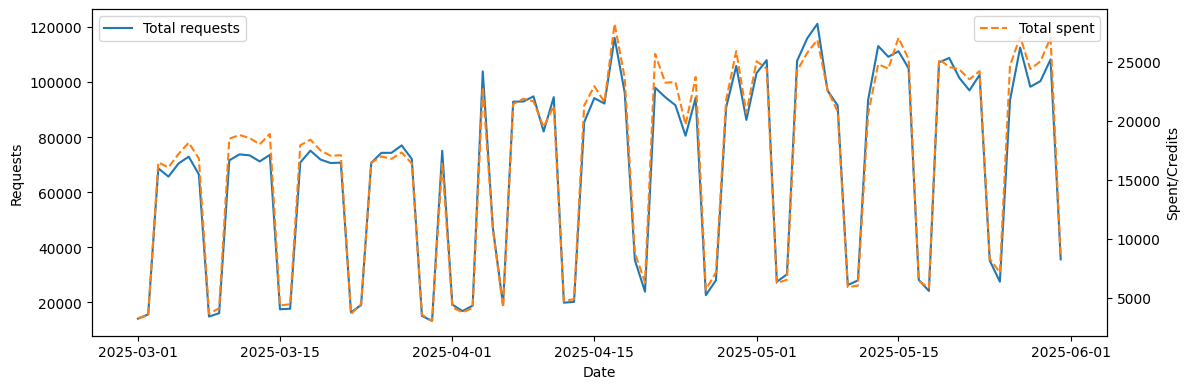

In [65]:
# Visualization
# 1- Daily information visualization

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(daily["day_id"], daily["requests_cnt"], label="Total requests")
ax1.set_ylabel("Requests")
ax2 = ax1.twinx() # second y axis
ax2.plot(daily["day_id"], daily["spent_amount"], color = "C1", linestyle = "--", label = "Total spent" )
ax2.set_ylabel("Spent/Credits")
ax1.set_xlabel("Date")
ax1.legend(loc = "upper left")
ax2.legend(loc = "upper right")
fig.tight_layout() # to avoid subplots and figure elements overlap
plt.savefig(os.path.join(directory_path, "Analysis_outputs/daily_requests_spent.png"), dpi = 150)
plt.show()

In [ ]:
"""
From this graph, requests seemed to be made more frequently in May 2025, with 
a peak in April 2025.

Investigating the tendency in this period may reveal a pattern, a cause
for more frequent requests.
"""

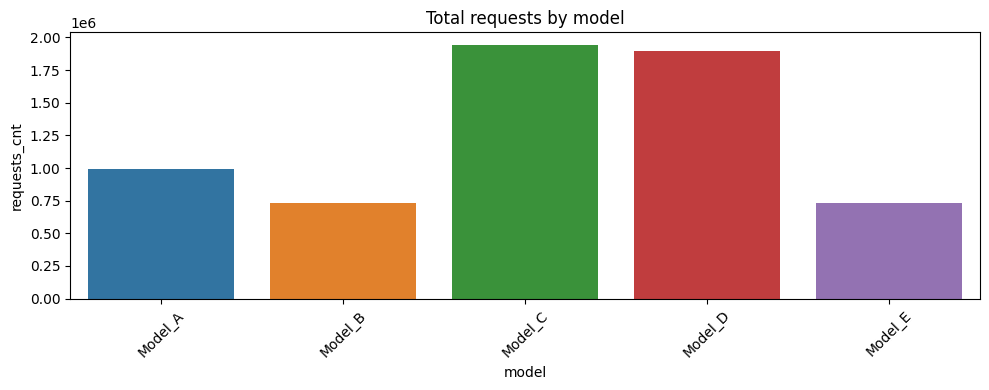

In [66]:
# 2- Requests by model 
# check section "Some additional aggregations" for aggregation requests_by_model 

plt.figure(figsize=(10,4))

sns.barplot(data=model_totals, x = "model", y = "requests_cnt")
plt.title("Total requests by model")
plt.xticks(rotation = 45) #  for labels from the x-axis to not overlap
plt.tight_layout()
plt.savefig(os.path.join(directory_path, "Analysis_outputs/requests_by_model,png"), dpi=150)
plt.show()


In [ ]:
"""
From this bar chart, it is easily shown that Model_C and Model_D are 
the most used by users, from the request count

The least used models are Model_B and Model_E

Model_A is slightly more used that the previous models but still far less
used than Model_C and Model_D

"""

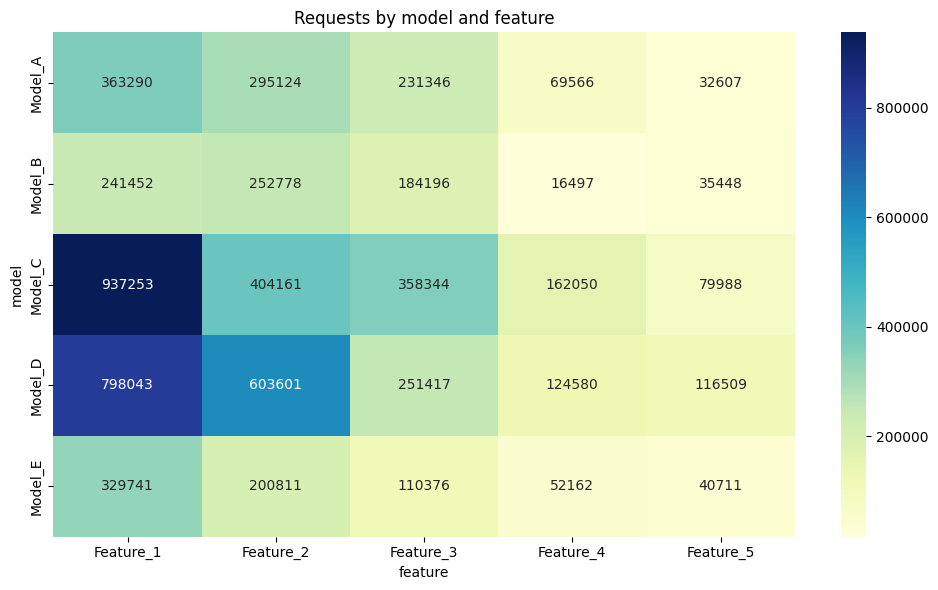

In [67]:
# 3- Heatmap model - feature

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu") # only integers values in the heatmap and color palette from low to high : yellow->green->blue
plt.title("Requests by model and feature")
plt.tight_layout()
plt.savefig(os.path.join(directory_path, "Analysis_outputs/heatmap_model_feature.png"), dpi=150)
plt.show()

In [ ]:
"""
From this heatmap, the most used combinations would be :
 1) Model_C x Feature_1
 2) Model_D x Feature_1
 3) Model_D X Feature_2
 
Also it can also be concluded that Feature_1, Feature_2 and 
a little bit Feature_3, according to the heatmap, 
are the most appreciated features, from the most popular models C and D
"""

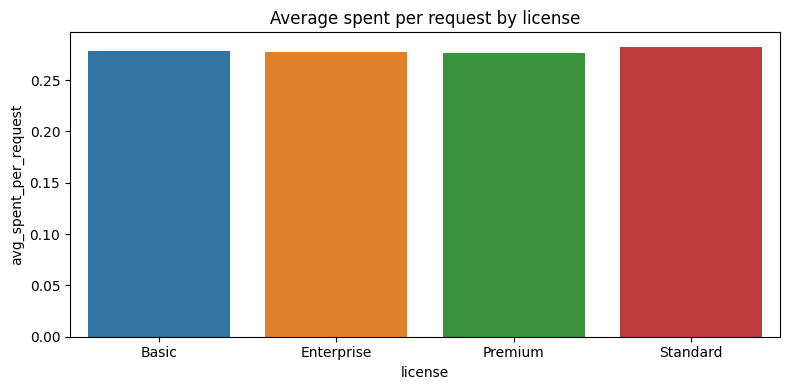

In [68]:
# 4- Average spent per request by licence

# check section "Some additional aggregations" for agg avg_spent per 
# request by licence / license_stats

plt.figure(figsize=(8,4))
sns.barplot(data = license_stats, x = "license", y = "avg_spent_per_request")
plt.title("Average spent per request by license")
plt.tight_layout()
plt.savefig(os.path.join(directory_path, "Analysis_outputs/avg_spent_per_request_by_license.png"), dpi=150)
plt.show()

In [ ]:
"""
From this barplot, the value of a request seems independent of the 
license type.

So a similar amount per request is spent by users across licenses. 
License type itself may not be a strong driver.

A request value from the standard license seems slighly higher than others.

It may suggest that requests from standard licence are a little bit
more monetizable - 
standard users may be facing some limits that encourage
slightly higher spend 

However compared to the previous findings/analysis, it seems more appropriate
to assume that the total revenue may depend on number of users, number of requests, per user

"""

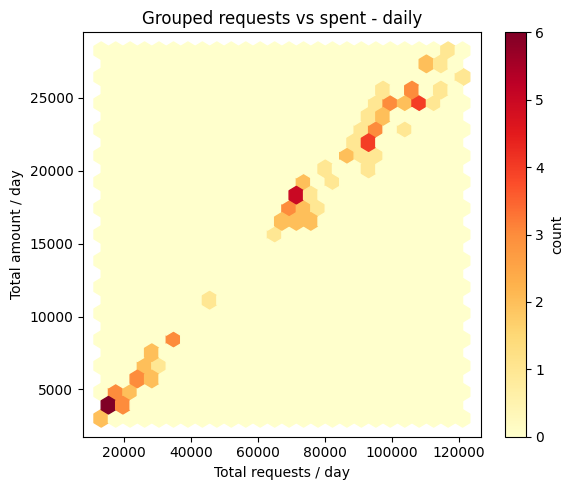

In [69]:
# 5 - Request vs spent 
plt.figure(figsize=(6,5))
plt.hexbin(agg_daily["total_requests"], agg_daily["total_spent"], gridsize = 25, cmap='YlOrRd')
plt.colorbar(label="count")
plt.xlabel("Total requests / day")
plt.ylabel("Total amount / day")
plt.title("Grouped requests vs spent - daily")
plt.tight_layout()
plt.savefig(os.path.join(directory_path, "Analysis_outputs/grouped_requests_vs_spent.png"), dpi=150)
plt.show()

In [ ]:
"""
From the hexagon map, there is a pattern. Most days (orange to red hexagon)
cluster along a line roughly following y = ax + b(a,b constant)

It means that total spending increases with total requests most of the time

But there is also a fixed amount spent independently of the number of requests

"""

In [ ]:
"""
Some linear regression - 
"""

In [36]:
# Correlation and regression
corr = agg_daily["total_requests"].corr(agg_daily["total_spent"])
print("Correlation - daily total requests vs total spent :", corr)

Correlation - daily total requests vs total spent : 0.9939812878192017


In [ ]:
"""
The Pearson correlation value is 0,99 - which is very close to 1
It means there is a strong positive correlation
This confirms the hexagon maps information: 
The total spent by users grows almost linearly woth total requests

"""

In [41]:
# Linear regression on per-row level  (user/day)
X = df[["requests_cnt"]].values.reshape(-1,1)
y = df["spent_amount"].values
ln_reg = LinearRegression().fit(X,y)
print("Linear model: spent = {:.4f} * requests + {:.4f}".format(ln_reg.coef_[0], ln_reg.intercept_))
print("R^2:", ln_reg.score(X,y))

Linear model: spent = 0.2113 * requests + 1.3974
R^2: 0.8914703168455216


In [ ]:
"""
This linear regression confirms that total of spending can be modeled as
a line, so as : spent = 0,2113 x requests + 1,3974

This means each requeest adds roughly 0,21 units to spending, while even 
on days without requests there is a baseline spend of 1,3974 units.

The R^2 score indicates a strong linear relatonship.

This confirms that spending per request is fairly consistent across days,
and the total requests are the main driver of total spent, with still 
some variations

"""

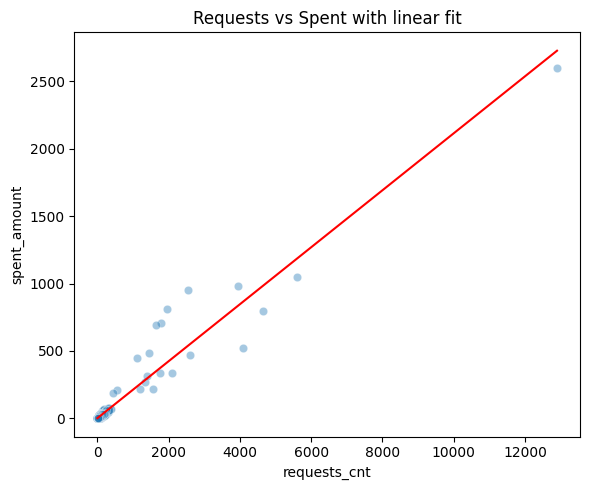

In [70]:
# Plot regression
# Sampled to reduce overplotting
sample_df = df.sample(frac=min(1.0, 5000/len(df)), random_state=42)
plt.figure(figsize=(6,5))
sns.scatterplot(data=sample_df, x="requests_cnt", y = "spent_amount", alpha=0.4)
x_lin = np.linspace(sample_df["requests_cnt"].min(), sample_df["requests_cnt"].max(),100)
plt.plot(x_lin, ln_reg.coef_[0]*x_lin + ln_reg.intercept_, color='red')
plt.title("Requests vs Spent with linear fit")
plt.tight_layout()
plt.savefig(os.path.join(directory_path,"Analysis_outputs/regression_requests_vs_spent.png"), dpi=150)
plt.show()

In [ ]:
"""
It is now clear that as the number of requests grows
then spending is also growing.

It may be interesting to find out if there are users making more requests
than others and then spending significantly more.

Finding power users.
"""

In [71]:
# Power users (top 5%) 
user_totals = user_aggregation.sort_values("total_requests", ascending=False)
condition = user_totals["total_requests"].quantile(0.95)
power_users = user_totals[user_totals["total_requests"] >= condition]
print(f"Power users threshold (95th): {condition}")
print(power_users.head())
user_totals.to_csv(os.path.join(directory_path,"Analysis_outputs/user_totals_sorted.csv"), index=False)


# for a comparison
total_power_requests = power_users["total_requests"].sum()
print("Total requests made by power users: ", total_power_requests)

total_requests_all = user_aggregation["total_requests"].sum()
print(f"Total requests from all users: {total_requests_all}")

Power users threshold (95th): 9873.25
           uuid  total_requests  total_spent first_seen  last_seen  \
1795   user_935        285050.0     54032.42 2025-04-04 2025-05-30   
1797   user_937        154300.0     28361.01 2025-04-04 2025-05-31   
1793   user_933        120850.0     44329.76 2025-04-04 2025-05-29   
1796   user_936        101300.0     32019.97 2025-04-04 2025-05-30   
934   user_1928         53800.0      9808.69 2025-04-04 2025-05-29   

      days_active  avg_req_per_active_day  
1795           30             9501.666667  
1797           27             5714.814815  
1793           29             4167.241379  
1796           25             4052.000000  
934            23             2339.130435  
Total requests made by power users:  1825719.0
Total requests from all users: 6292051.0


In [ ]:
"""
Out of 6292051 requests the top 5 users made 1825719 requests, which represent 
around 29% of the activity 

Taking this into consideration, it would be profitable to encourage
people to become "power users" (givind rewards for example)
"""

In [72]:
# The final recommandation template 
recommendations = [
    "Focusing on engagement/marketing - Since average spending per request is consistent across licenses, increasing the usage frequency will have the biggest impact", 
    "Identifying and reward power users as they are significantly impacting the growth of spending",
    "Focusing on development of Model C and D (combined with feature 1 and 2 a little bit)",
    "Inestigating April and May's peaks may reveal a tendency for frequent requests"
]

print("Possible Recommendations: \n")
for rec in recommendations:
    print('-', rec)

Possible Recommendations: 

- Focusing on engagement/marketing - Since average spending per request is consistent across licenses, increasing the usage frequency will have the biggest impact
- Identifying and reward power users as they are significantly impacting the growth of spending
- Focusing on development of Model C and D (combined with feature 1 and 2 a little bit)
- Inestigating April and May's peaks may reveal a tendency for frequent requests
